In [ ]:
import pandas as pd

## **Lire et préparation des données**

In [ ]:
df = pd.read_csv("US Monthly Air Passengers.csv", parse_dates={"date":["YEAR", "MONTH"]})
df["date"] = df["date"].dt.to_period("M")   # On a pas d'informations sur le jour et l'heure, seulement sur l'année et le mois
df = df[df["date"]<pd.Period("2019-1", freq="M")]

In [ ]:
df.head()

,date,Sum_PASSENGERS,AIRLINE_ID,CARRIER_NAME,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,ORIGIN_STATE_NM,ORIGIN_COUNTRY,ORIGIN_COUNTRY_NAME,DEST,DEST_CITY_NAME,DEST_STATE_ABR,DEST_STATE_NM,DEST_COUNTRY,DEST_COUNTRY_NAME
0,2015-03,0,NaN,NaN,AEX,"Alexandria, LA",LA,Louisiana,US,United States,AEX,"Alexandria, LA",LA,Louisiana,US,United States
1,2015-04,0,NaN,NaN,AEX,"Alexandria, LA",LA,Louisiana,US,United States,AFW,"Dallas/Fort Worth, TX",TX,Texas,US,United States
2,2015-03,0,NaN,NaN,AEX,"Alexandria, LA",LA,Louisiana,US,United States,ATL,"Atlanta, GA",GA,Georgia,US,United States
3,2015-01,89,NaN,NaN,AEX,"Alexandria, LA",LA,Louisiana,US,United States,BOG,"Bogota, Colombia",NaN,NaN,CO,Colombia
4,2015-03,108,NaN,NaN,AEX,"Alexandria, LA",LA,Louisiana,US,United States,BOG,"Bogota, Colombia",NaN,NaN,CO,Colombia


In [ ]:
df[df["DEST_COUNTRY"]=="GA"]

,date,Sum_PASSENGERS,AIRLINE_ID,CARRIER_NAME,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,ORIGIN_STATE_NM,ORIGIN_COUNTRY,ORIGIN_COUNTRY_NAME,DEST,DEST_CITY_NAME,DEST_STATE_ABR,DEST_STATE_NM,DEST_COUNTRY,DEST_COUNTRY_NAME
2629643,2001-11,0,"20,100.00",Polar Air Cargo Airways,JFK,"New York, NY",NY,New York,US,United States,LBV,"Libreville, Gabon",NaN,NaN,GA,Gabon
2884093,2017-06,0,"20,110.00",Antonov Company,SBD,"San Bernardino, CA",CA,California,US,United States,LBV,"Libreville, Gabon",NaN,NaN,GA,Gabon
3017534,2009-03,0,"20,190.00",Southern Air Inc.,ATL,"Atlanta, GA",GA,Georgia,US,United States,LBV,"Libreville, Gabon",NaN,NaN,GA,Gabon
3586633,2005-10,0,"20,308.00",Centurion Cargo Inc.,MIA,"Miami, FL",FL,Florida,US,United States,LBV,"Libreville, Gabon",NaN,NaN,GA,Gabon
5585680,2008-08,0,"20,428.00",Volga-Dnepr Airlines,IAH,"Houston, TX",TX,Texas,US,United States,LBV,"Libreville, Gabon",NaN,NaN,GA,Gabon
5585681,2012-11,0,"20,428.00",Volga-Dnepr Airlines,IAH,"Houston, TX",TX,Texas,US,United States,LBV,"Libreville, Gabon",NaN,NaN,GA,Gabon
5585972,2005-10,0,"20,428.00",Volga-Dnepr Airlines,LAX,"Los Angeles, CA",CA,California,US,United States,LBV,"Libreville, Gabon",NaN,NaN,GA,Gabon


<Axes: title={'center': 'Nombre de passagers mensuel ayant pour destination FR'}, xlabel='Date (mois et année)', ylabel='Nombre de passagers'>

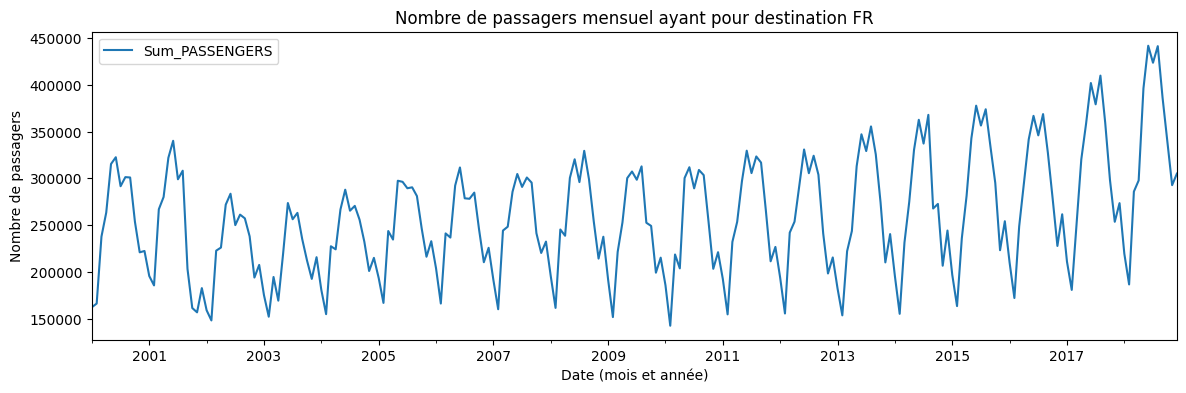

In [ ]:
# Nombre de passagers allant dans un pays chaque mois
country_code = "FR"
data = df[df["DEST_COUNTRY"]==country_code][["date", "Sum_PASSENGERS"]].groupby("date").sum()
data.plot(title=f"Nombre de passagers mensuel ayant pour destination {country_code}",
          xlabel="Date (mois et année)",
          ylabel="Nombre de passagers",
          figsize=(14,4))

## **Décomposition STL**

In [ ]:
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
nb_passengers = data["Sum_PASSENGERS"].values

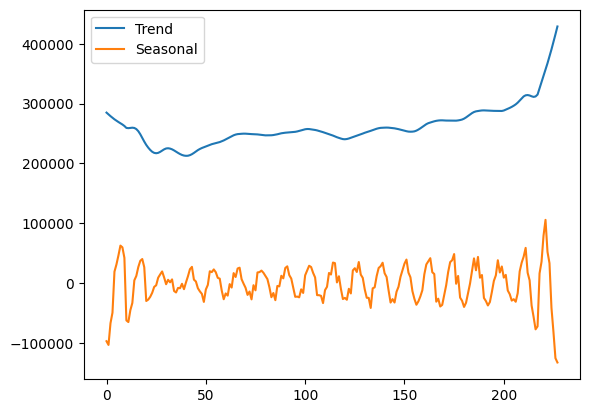

In [ ]:
stl = STL(nb_passengers, period=10)
result = stl.fit()
plt.plot(result.trend, label="Trend")
plt.plot(result.seasonal, label="Seasonal")
plt.legend()

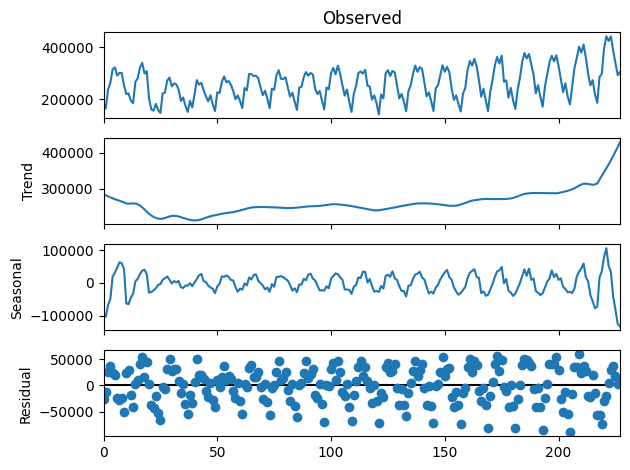

In [ ]:
result.plot()
plt.show()

## **Prédictions naïves**

In [ ]:
pip install sktime

In [ ]:
from sktime.forecasting.naive import NaiveForecaster
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error as smape_loss
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import temporal_train_test_split

In [ ]:
def plot_ys(*args, **kwargs):
        # restore 2020 behaviour (jfb) --> plot_ys supprimé
        nb_series=len(args)
        plot_series(*args, **kwargs, markers=['' for k in range(nb_series)])

In [ ]:
y_train, y_test = temporal_train_test_split(nb_passengers, test_size=30)

In [ ]:
print(type(y_train))
print(y_train.shape)

print(type(y_test))
print(y_test.shape)

<class 'numpy.ndarray'>
(198, 1)
<class 'numpy.ndarray'>
(30, 1)


In [ ]:
# y_train = pd.Series(y_train)
# y_test = pd.Series(y_test)

y_train = pd.Series(y_train.flatten())
y_test = pd.Series(y_test.flatten())

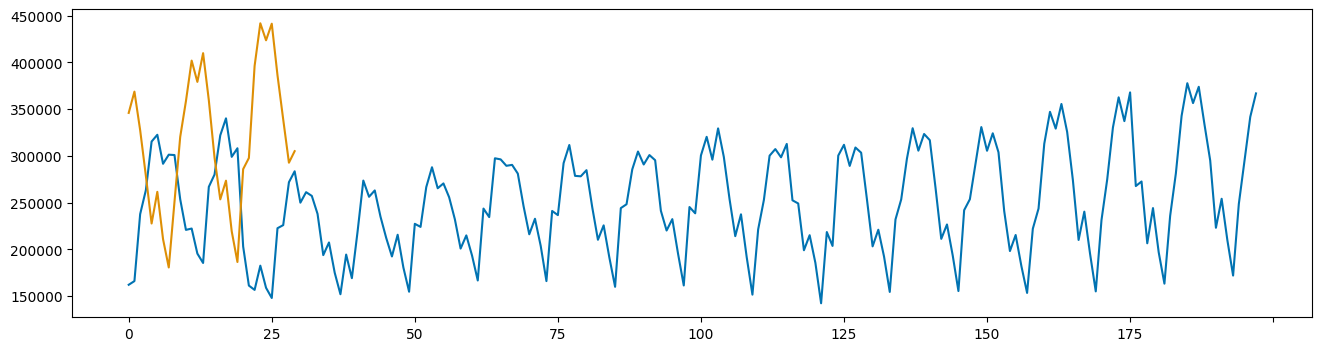

In [ ]:
plot_ys(y_train, y_test)

SMAPE_LOSS: 0.28249313971975637


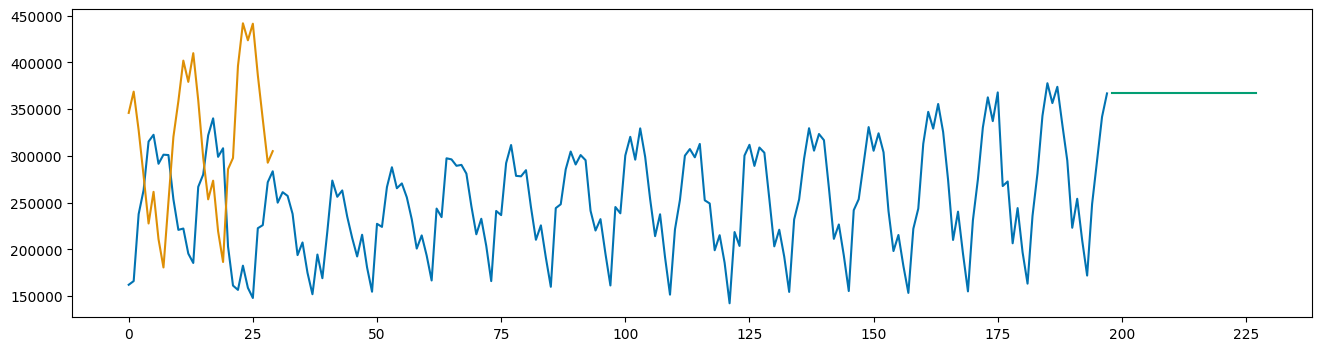

In [ ]:
fh = np.arange(1,len(y_test)+1)

forecaster = NaiveForecaster(strategy='last')
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_ys(y_train, y_test, y_pred)
print(f"SMAPE_LOSS: {smape_loss(y_test, y_pred)}")

SMAPE_LOSS: 0.29949489198831086


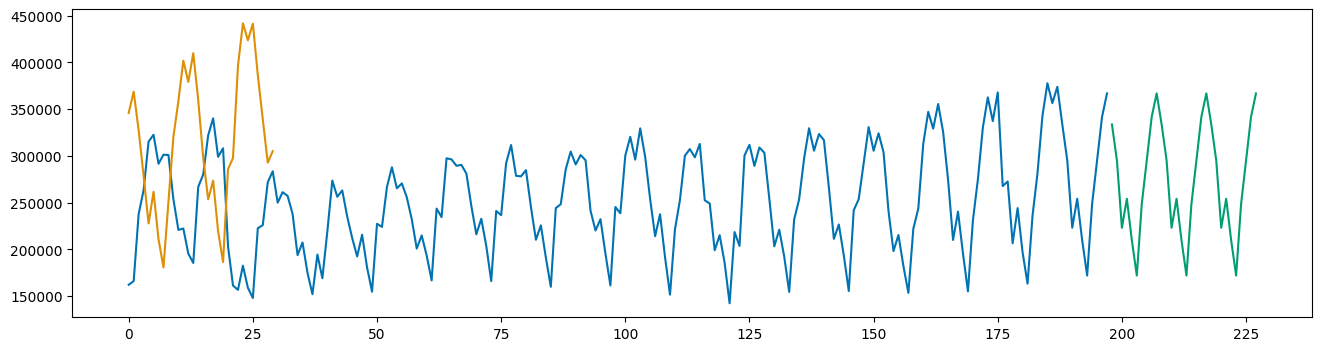

In [ ]:
forecaster = NaiveForecaster(strategy='last', sp=10)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_ys(y_train, y_test, y_pred)
print(f"SMAPE_LOSS: {smape_loss(y_test, y_pred)}")

## **Prédictions**

In [ ]:
from sktime.forecasting.compose import make_reduction
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

SMAPE_LOSS: 0.13537377525789535


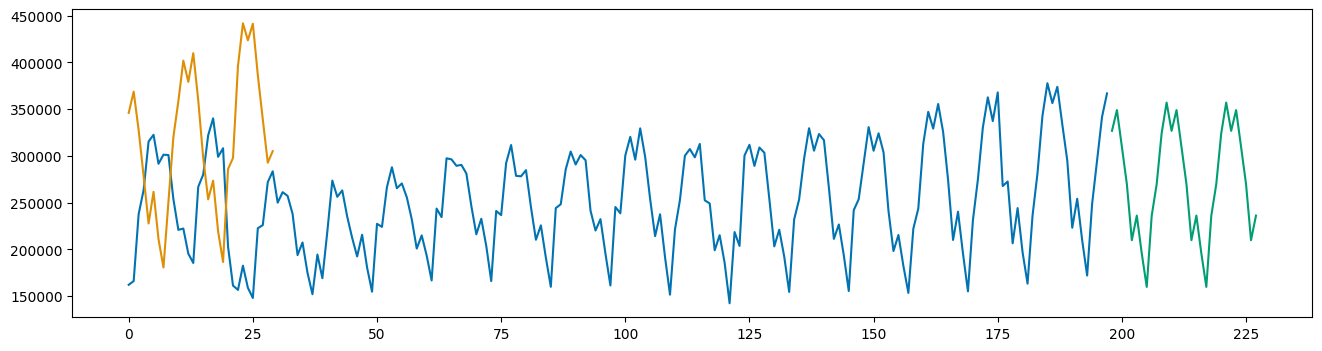

In [ ]:
regressor = KNeighborsRegressor()
forecaster = make_reduction(regressor, strategy="recursive", window_length=100)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_ys(y_train, y_test, y_pred)
print(f"SMAPE_LOSS: {smape_loss(y_test, y_pred)}")

SMAPE_LOSS: 0.1007768932825302


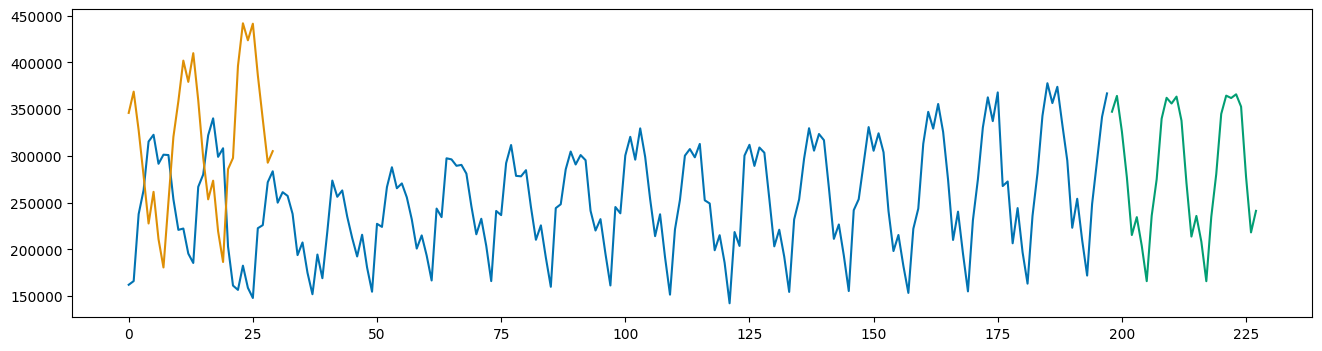

In [ ]:
regressor = RandomForestRegressor()
forecaster = make_reduction(regressor, strategy="recursive", window_length=100)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_ys(y_train, y_test, y_pred)
print(f"SMAPE_LOSS: {smape_loss(y_test, y_pred)}")

SMAPE_LOSS: 0.2437191572111121


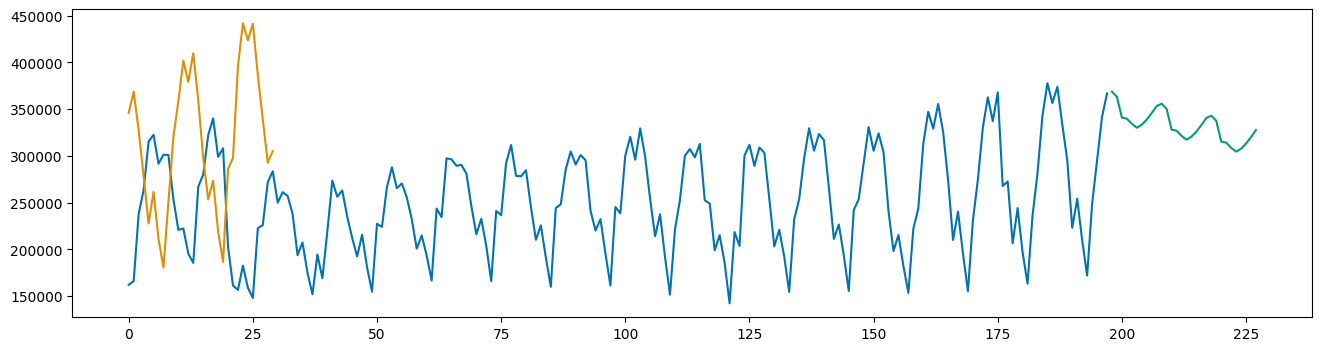

In [ ]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

from sktime.forecasting.exp_smoothing import ExponentialSmoothing
forecaster = ExponentialSmoothing(trend="add", seasonal="additive",
                                  sp=10)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_ys(y_train, y_test, y_pred)
print(f"SMAPE_LOSS: {smape_loss(y_test, y_pred)}")

## Prédiction Deep Learning

### Data Prep

In [ ]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from collections import UserDict
from glob import glob
from IPython.display import Image
%matplotlib inline


pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore")

In [ ]:
from keras.models import Model, Sequential
from keras.layers import Conv1D, Dense, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
#data.set_index('date', inplace=True)

In [ ]:
valid_start_dt = '2015-1'
test_start_dt = '2017-1'
# valid_start_dt = '2016-10'
# test_start_dt = '2018-10'

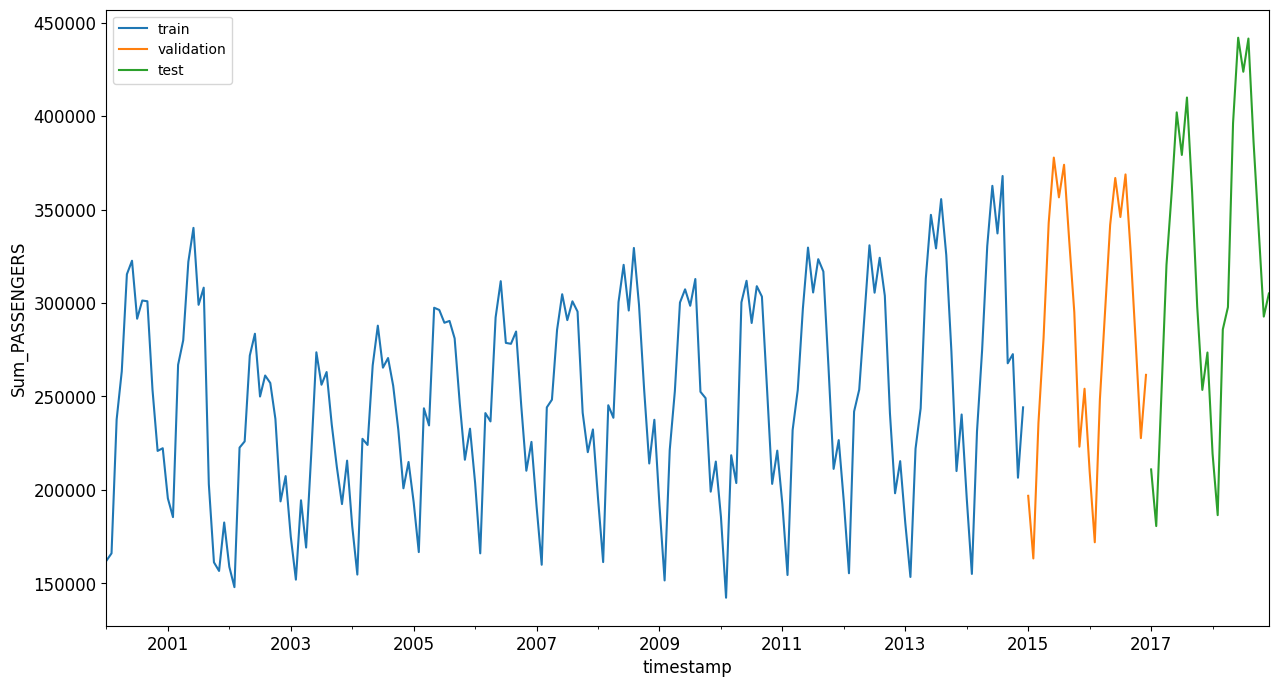

In [ ]:
# df[df['date'] < valid_start_dt][['Sum_PASSENGERS']].rename(columns={'Sum_PASSENGERS':'train'}) \
#     .join(df[(df['date'] >=valid_start_dt) & (df['date'] < test_start_dt)][['Sum_PASSENGERS']] \
#           .rename(columns={'Sum_PASSENGERS':'validation'}), how='outer') \
#     .join(df[test_start_dt:][['Sum_PASSENGERS']].rename(columns={'Sum_PASSENGERS':'test'}), how='outer') \
#     .plot(y=['train', 'validation', 'test'], figsize=(15, 8), fontsize=12)
data[data.index < valid_start_dt][['Sum_PASSENGERS']].rename(columns={'Sum_PASSENGERS': 'train'}) \
    .join(data[(data.index >= valid_start_dt) & (data.index < test_start_dt)][['Sum_PASSENGERS']] \
          .rename(columns={'Sum_PASSENGERS': 'validation'}), how='outer') \
    .join(data[test_start_dt:][['Sum_PASSENGERS']].rename(columns={'Sum_PASSENGERS': 'test'}), how='outer') \
    .plot(y=['train', 'validation', 'test'], figsize=(15, 8), fontsize=12)

plt.xlabel('timestamp', fontsize=12)
plt.ylabel('Sum_PASSENGERS', fontsize=12)
plt.show()

In [ ]:
#T = 1 #pr avec covid
T = 4 #sans covid
HORIZON = 1

In [ ]:
train = data.copy()[data.index < valid_start_dt][['Sum_PASSENGERS']]

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train['Sum_PASSENGERS'] = scaler.fit_transform(train)
train.head(10)

,Sum_PASSENGERS
date,
2000-01,0.09
2000-02,0.11
2000-03,0.42
2000-04,0.54
2000-05,0.77
2000-06,0.80
2000-07,0.66
2000-08,0.70
2000-09,0.70


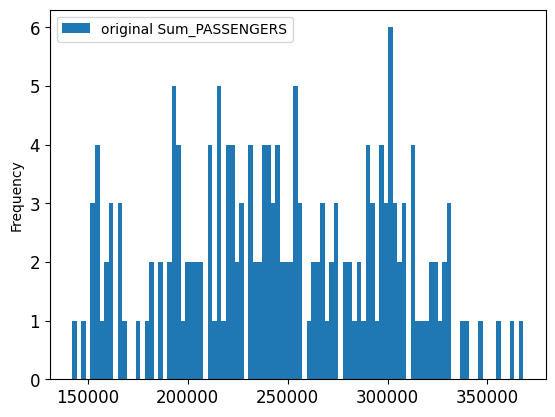

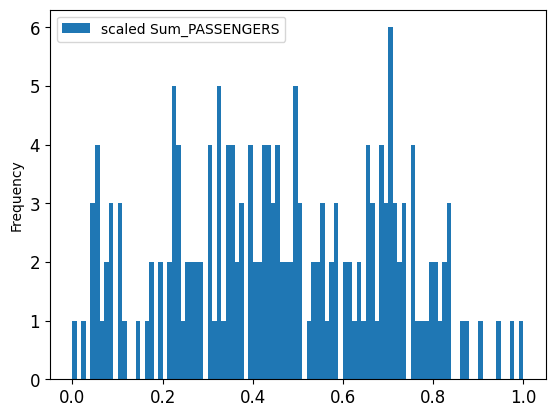

In [ ]:
data[data.index < valid_start_dt][['Sum_PASSENGERS']].rename(columns={'Sum_PASSENGERS':'original Sum_PASSENGERS'}).plot.hist(bins=100, fontsize=12)
train.rename(columns={'Sum_PASSENGERS':'scaled Sum_PASSENGERS'}).plot.hist(bins=100, fontsize=12)
plt.show()

In [ ]:
train

,Sum_PASSENGERS
date,
2000-01,0.09
2000-02,0.11
2000-03,0.42
2000-04,0.54
2000-05,0.77
...,...
2014-08,1.00
2014-09,0.56
2014-10,0.58


In [ ]:
train_shifted = train.copy()
train_shifted['y_t+1'] = train_shifted['Sum_PASSENGERS'].shift(-1, freq='M')
train_shifted.head(10)

,Sum_PASSENGERS,y_t+1
date,,
2000-01,0.09,0.11
2000-02,0.11,0.42
2000-03,0.42,0.54
2000-04,0.54,0.77
2000-05,0.77,0.80
2000-06,0.80,0.66
2000-07,0.66,0.70
2000-08,0.70,0.70
2000-09,0.70,0.49


In [ ]:
for t in range(1, T+1):
    train_shifted['Sum_PASSENGERS_t-'+str(T-t)] = train_shifted['Sum_PASSENGERS'].shift(T-t, freq='M')
train_shifted = train_shifted.rename(columns={'Sum_PASSENGERS':'Sum_PASSENGERS_original'})
train_shifted.head(10)

,Sum_PASSENGERS_original,y_t+1,Sum_PASSENGERS_t-3,Sum_PASSENGERS_t-2,Sum_PASSENGERS_t-1,Sum_PASSENGERS_t-0
date,,,,,,
2000-01,0.09,0.11,NaN,NaN,NaN,0.09
2000-02,0.11,0.42,NaN,NaN,0.09,0.11
2000-03,0.42,0.54,NaN,0.09,0.11,0.42
2000-04,0.54,0.77,0.09,0.11,0.42,0.54
2000-05,0.77,0.80,0.11,0.42,0.54,0.77
2000-06,0.80,0.66,0.42,0.54,0.77,0.80
2000-07,0.66,0.70,0.54,0.77,0.80,0.66
2000-08,0.70,0.70,0.77,0.80,0.66,0.70
2000-09,0.70,0.49,0.80,0.66,0.70,0.70


In [ ]:
train_shifted = train_shifted.dropna(how='any')
train_shifted.head(5)

,Sum_PASSENGERS_original,y_t+1,Sum_PASSENGERS_t-3,Sum_PASSENGERS_t-2,Sum_PASSENGERS_t-1,Sum_PASSENGERS_t-0
date,,,,,,
2000-04,0.54,0.77,0.09,0.11,0.42,0.54
2000-05,0.77,0.80,0.11,0.42,0.54,0.77
2000-06,0.80,0.66,0.42,0.54,0.77,0.80
2000-07,0.66,0.70,0.54,0.77,0.80,0.66
2000-08,0.70,0.70,0.77,0.80,0.66,0.70


In [ ]:
y_train = train_shifted[['y_t+1']].to_numpy()

In [ ]:
y_train.shape

(176, 1)

In [ ]:
y_train[:3]

array([[0.77],
       [0.8 ],
       [0.66]])

In [ ]:
X_train = train_shifted[['Sum_PASSENGERS_t-'+str(T-t) for t in range(1, T+1)]].to_numpy()
X_train = X_train[... , np.newaxis]

In [ ]:
X_train.shape

(176, 4, 1)

In [ ]:
X_train[:3]

array([[[0.09],
        [0.11],
        [0.42],
        [0.54]],

       [[0.11],
        [0.42],
        [0.54],
        [0.77]],

       [[0.42],
        [0.54],
        [0.77],
        [0.8 ]]])

In [ ]:
train_shifted.head(3)

,Sum_PASSENGERS_original,y_t+1,Sum_PASSENGERS_t-3,Sum_PASSENGERS_t-2,Sum_PASSENGERS_t-1,Sum_PASSENGERS_t-0
date,,,,,,
2000-04,0.54,0.77,0.09,0.11,0.42,0.54
2000-05,0.77,0.80,0.11,0.42,0.54,0.77
2000-06,0.80,0.66,0.42,0.54,0.77,0.80


In [ ]:
from dateutil.relativedelta import relativedelta

In [ ]:
relativedelta(months=T-1)

relativedelta(months=+3)

In [ ]:
#valid_start_dt.strftime('%Y-%m')

In [ ]:
#dt.datetime.strptime(valid_start_dt.strftime('%Y-%m'), '%Y-%m')

In [ ]:
#data.index

In [ ]:
#valid_start_dt

In [ ]:
look_back_dt = dt.datetime.strptime(valid_start_dt, '%Y-%m') - relativedelta(months=T-1)
look_back_dt = look_back_dt.strftime('%Y-%m')
valid = data.copy()[(data.index >=look_back_dt) & (data.index < test_start_dt)][['Sum_PASSENGERS']]
valid.head()

,Sum_PASSENGERS
date,
2014-10,272633
2014-11,206492
2014-12,244147
2015-01,196810
2015-02,163289


In [ ]:
valid['Sum_PASSENGERS'] = scaler.transform(valid)
valid.head()

,Sum_PASSENGERS
date,
2014-10,0.58
2014-11,0.28
2014-12,0.45
2015-01,0.24
2015-02,0.09


In [ ]:
valid_shifted = valid.copy()
valid_shifted['y+1'] = valid_shifted['Sum_PASSENGERS'].shift(-1, freq='M')
for t in range(1, T+1):
    valid_shifted['Sum_PASSENGERS_t-'+str(T-t)] = valid_shifted['Sum_PASSENGERS'].shift(T-t, freq='M')
valid_shifted = valid_shifted.dropna(how='any')
y_valid = valid_shifted['y+1'].to_numpy()
X_valid = valid_shifted[['Sum_PASSENGERS_t-'+str(T-t) for t in range(1, T+1)]].to_numpy()
X_valid = X_valid[..., np.newaxis]

In [ ]:
y_valid.shape

(23,)

In [ ]:
X_valid.shape

(23, 4, 1)

### CNN

In [ ]:
from keras.models import Model, Sequential
from keras.layers import Conv1D, Dense, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
LATENT_DIM = 5 # Nombre de filtres
KERNEL_SIZE = 2
BATCH_SIZE = 32
EPOCHS = 10

In [ ]:
model = Sequential()
model.add(Conv1D(LATENT_DIM, kernel_size=KERNEL_SIZE, padding='causal', strides=1, activation='relu', dilation_rate=1, input_shape=(T, 1)))
model.add(Conv1D(LATENT_DIM, kernel_size=KERNEL_SIZE, padding='causal', strides=1, activation='relu', dilation_rate=2))
model.add(Conv1D(LATENT_DIM, kernel_size=KERNEL_SIZE, padding='causal', strides=1, activation='relu', dilation_rate=4))
model.add(Flatten())
model.add(Dense(HORIZON, activation='linear'))

In [ ]:
model.summary()

Model: "sequential_67"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_108 (Conv1D)         (None, 4, 5)              15        
                                                                 
 conv1d_109 (Conv1D)         (None, 4, 5)              55        
                                                                 
 conv1d_110 (Conv1D)         (None, 4, 5)              55        
                                                                 
 flatten_36 (Flatten)        (None, 20)                0         
                                                                 
 dense_67 (Dense)            (None, 1)                 21        
                                                                 
Total params: 146 (584.00 Byte)
Trainable params: 146 (584.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.compile(optimizer='Adam', loss='mse')

In [ ]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)

In [ ]:
best_val = ModelCheckpoint('model_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)

In [ ]:
history = model.fit(X_train,
          y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=(X_valid, y_valid),
          callbacks=[earlystop, best_val],
          verbose=1)

Epoch 1/10
6/6 [==============================] - 1s 51ms/step - loss: 0.1758 - val_loss: 0.2950
Epoch 2/10
6/6 [==============================] - 0s 14ms/step - loss: 0.1457 - val_loss: 0.2500
Epoch 3/10
6/6 [==============================] - 0s 17ms/step - loss: 0.1209 - val_loss: 0.2137
Epoch 4/10
6/6 [==============================] - 0s 14ms/step - loss: 0.1002 - val_loss: 0.1837
Epoch 5/10
6/6 [==============================] - 0s 14ms/step - loss: 0.0853 - val_loss: 0.1581
Epoch 6/10
6/6 [==============================] - 0s 13ms/step - loss: 0.0741 - val_loss: 0.1384
Epoch 7/10
6/6 [==============================] - 0s 13ms/step - loss: 0.0663 - val_loss: 0.1247
Epoch 8/10
6/6 [==============================] - 0s 13ms/step - loss: 0.0621 - val_loss: 0.1152
Epoch 9/10
6/6 [==============================] - 0s 13ms/step - loss: 0.0597 - val_loss: 0.1094
Epoch 10/10
6/6 [==============================] - 0s 13ms/step - loss: 0.0584 - val_loss: 0.1058


In [ ]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model.load_weights("model_{:02d}.h5".format(best_epoch))

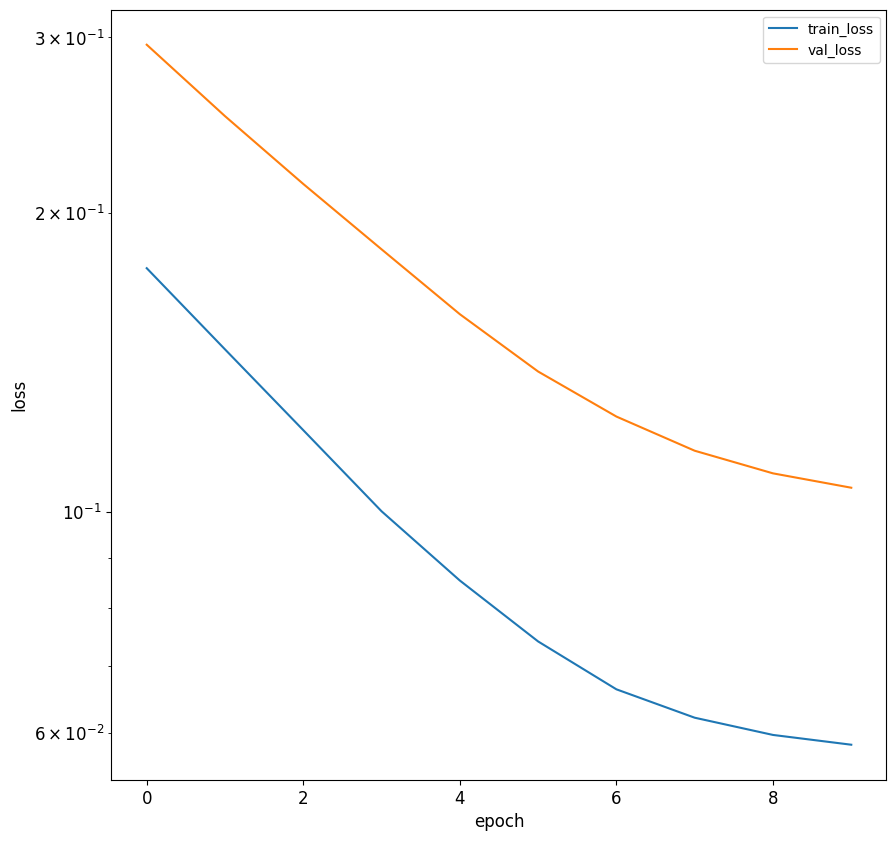

In [ ]:
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(10,10), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

In [ ]:
look_back_dt = dt.datetime.strptime(test_start_dt, '%Y-%m') - relativedelta(months=T-1)
look_back_dt = look_back_dt.strftime('%Y-%m')
test = data.copy()[test_start_dt:][['Sum_PASSENGERS']]
test.head()

,Sum_PASSENGERS
date,
2017-01,210936
2017-02,180614
2017-03,250817
2017-04,320376
2017-05,358598


In [ ]:
test['Sum_PASSENGERS'] = scaler.transform(test)
test.head()

,Sum_PASSENGERS
date,
2017-01,0.30
2017-02,0.17
2017-03,0.48
2017-04,0.79
2017-05,0.96


In [ ]:
test_shifted = test.copy()
test_shifted['y_t+1'] = test_shifted['Sum_PASSENGERS'].shift(-1, freq='M')
for t in range(1, T+1):
    test_shifted['Sum_PASSENGERS_t-'+str(T-t)] = test_shifted['Sum_PASSENGERS'].shift(T-t, freq='M')
test_shifted = test_shifted.dropna(how='any')
y_test = test_shifted['y_t+1'].to_numpy()
X_test = test_shifted[['Sum_PASSENGERS_t-'+str(T-t) for t in range(1, T+1)]].to_numpy()
X_test = X_test[... , np.newaxis]

In [ ]:
predictions = model.predict(X_test)
predictions

1/1 [==============================] - 0s 109ms/step


array([[0.41],
       [0.46],
       [0.61],
       [0.71],
       [0.76],
       [0.78],
       [0.73],
       [0.67],
       [0.57],
       [0.51],
       [0.44],
       [0.43],
       [0.44],
       [0.49],
       [0.65],
       [0.74],
       [0.84],
       [0.86],
       [0.81],
       [0.74]], dtype=float32)

In [ ]:
eval_df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
eval_df['timestamp'] = test_shifted.index
eval_df = pd.melt(eval_df, id_vars='timestamp', value_name='prediction', var_name='m')
eval_df['actual'] = np.transpose(y_test).ravel()
eval_df[['prediction', 'actual']] = scaler.inverse_transform(eval_df[['prediction', 'actual']])
eval_df.head()

,timestamp,m,prediction,actual
0,2017-04,t+1,"234,452.27","358,598.00"
1,2017-05,t+1,"246,817.13","402,009.00"
2,2017-06,t+1,"278,961.00","379,223.00"
3,2017-07,t+1,"302,481.38","409,955.00"
4,2017-08,t+1,"313,199.33","359,623.00"


In [ ]:
def mape(predictions, actuals):
    """Mean absolute percentage error"""
    return ((predictions - actuals).abs() / actuals).mean()

In [ ]:
mape(eval_df['prediction'], eval_df['actual'])

0.22040167715377104

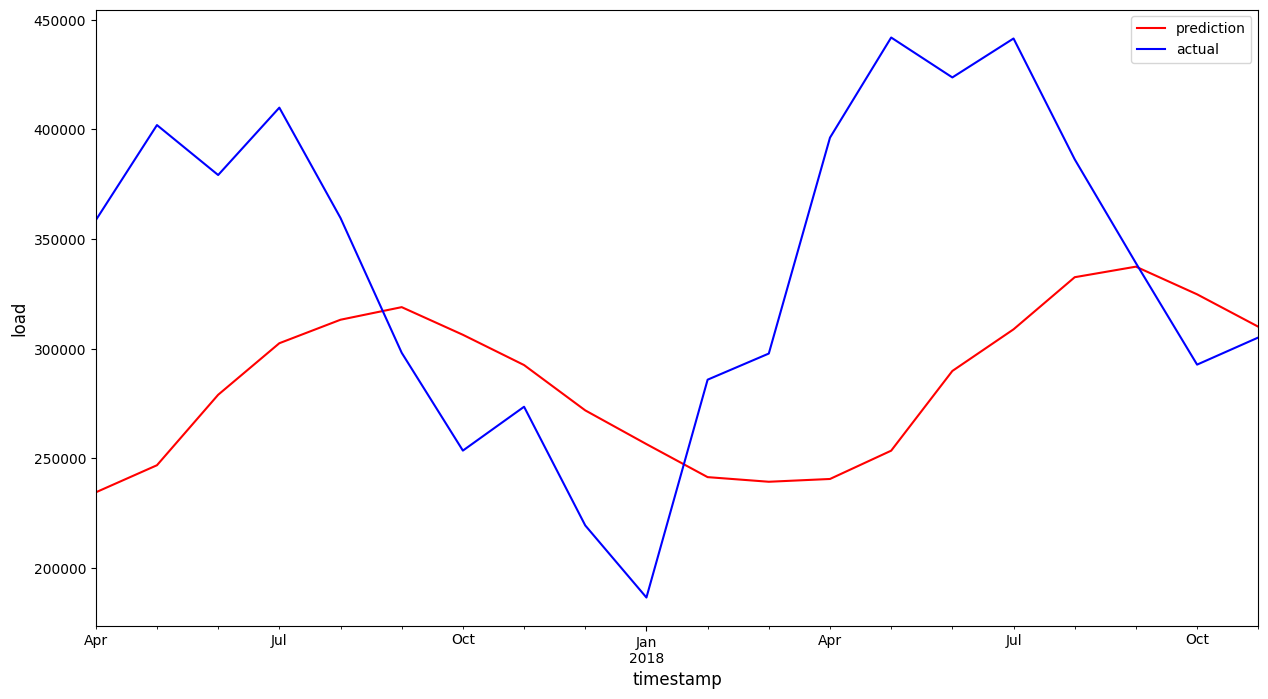

In [ ]:
eval_df[eval_df.timestamp<'2022-12'].plot(x='timestamp', y=['prediction', 'actual'], style=['r', 'b'], figsize=(15, 8))
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

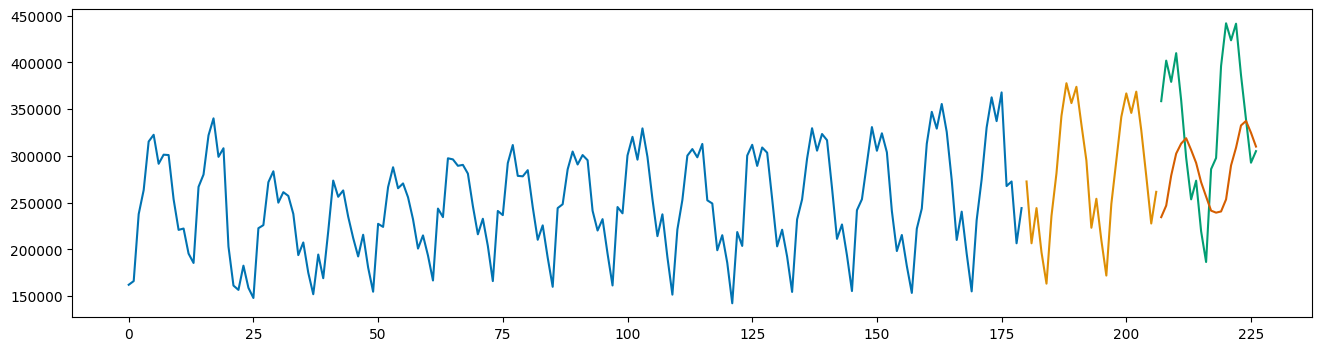

In [ ]:
train_to_plot = pd.Series(scaler.inverse_transform(train)[:,0])

validation_to_plot = pd.Series(scaler.inverse_transform(valid)[:,0])
validation_to_plot.index+=train_to_plot.index.stop


true_to_plot = eval_df["actual"]
true_to_plot.index+=validation_to_plot.index.stop

predict_to_plot = eval_df["prediction"]
predict_to_plot.index+=validation_to_plot.index.stop

plot_ys(train_to_plot, validation_to_plot, true_to_plot, predict_to_plot)

### RNN

In [ ]:
from keras.models import Model, Sequential
from keras.layers import GRU, Dense
from keras.callbacks import EarlyStopping

In [ ]:
LATENT_DIM = 5 # number of units in the RNN layer
BATCH_SIZE = 32 # number of samples per mini-batch
EPOCHS = 10 # maximum number of times the training algorithm will cycle through all samples

In [ ]:
model = Sequential()
model.add(GRU(LATENT_DIM, input_shape=(T, 1)))
model.add(Dense(HORIZON))

In [ ]:
model.compile(optimizer='RMSprop', loss='mse')

In [ ]:
model.summary()

Model: "sequential_68"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_31 (GRU)                (None, 5)                 120       
                                                                 
 dense_68 (Dense)            (None, 1)                 6         
                                                                 
Total params: 126 (504.00 Byte)
Trainable params: 126 (504.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)

In [ ]:
history = model.fit(X_train,
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_valid, y_valid),
                    callbacks=[earlystop],
                    verbose=1)

Epoch 1/10
6/6 [==============================] - 3s 123ms/step - loss: 0.1357 - val_loss: 0.2236
Epoch 2/10
6/6 [==============================] - 0s 14ms/step - loss: 0.0997 - val_loss: 0.1810
Epoch 3/10
6/6 [==============================] - 0s 13ms/step - loss: 0.0789 - val_loss: 0.1520
Epoch 4/10
6/6 [==============================] - 0s 17ms/step - loss: 0.0649 - val_loss: 0.1287
Epoch 5/10
6/6 [==============================] - 0s 15ms/step - loss: 0.0547 - val_loss: 0.1106
Epoch 6/10
6/6 [==============================] - 0s 18ms/step - loss: 0.0476 - val_loss: 0.0973
Epoch 7/10
6/6 [==============================] - 0s 18ms/step - loss: 0.0431 - val_loss: 0.0863
Epoch 8/10
6/6 [==============================] - 0s 14ms/step - loss: 0.0405 - val_loss: 0.0801
Epoch 9/10
6/6 [==============================] - 0s 15ms/step - loss: 0.0393 - val_loss: 0.0752
Epoch 10/10
6/6 [==============================] - 0s 16ms/step - loss: 0.0385 - val_loss: 0.0724


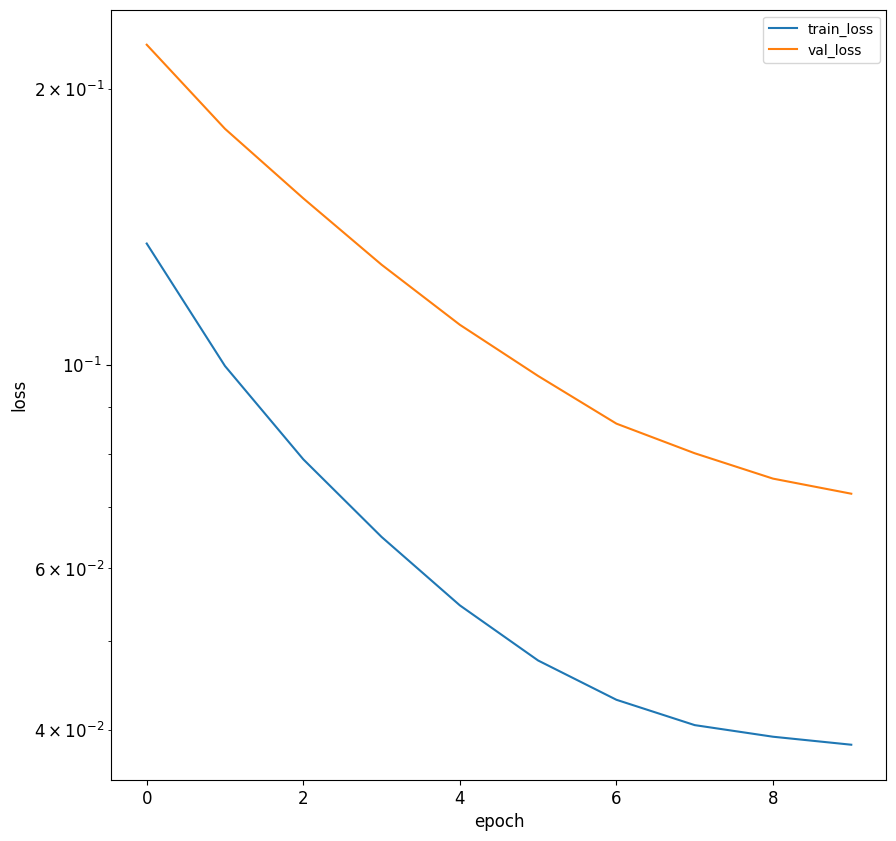

In [ ]:
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(10,10), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

In [ ]:
predictions = model.predict(X_test)
predictions

1/1 [==============================] - 1s 580ms/step


array([[0.53],
       [0.61],
       [0.67],
       [0.68],
       [0.7 ],
       [0.68],
       [0.61],
       [0.54],
       [0.52],
       [0.46],
       [0.39],
       [0.48],
       [0.52],
       [0.64],
       [0.71],
       [0.72],
       [0.74],
       [0.71],
       [0.66],
       [0.6 ]], dtype=float32)

In [ ]:
eval_df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
eval_df['timestamp'] = test_shifted.index
eval_df = pd.melt(eval_df, id_vars='timestamp', value_name='prediction', var_name='m')
eval_df['actual'] = np.transpose(y_test).ravel()
eval_df[['prediction', 'actual']] = scaler.inverse_transform(eval_df[['prediction', 'actual']])
eval_df.head()

,timestamp,m,prediction,actual
0,2017-04,t+1,"261,221.33","358,598.00"
1,2017-05,t+1,"279,135.65","402,009.00"
2,2017-06,t+1,"294,528.36","379,223.00"
3,2017-07,t+1,"295,979.75","409,955.00"
4,2017-08,t+1,"301,089.34","359,623.00"


In [ ]:
mape(eval_df['prediction'], eval_df['actual'])

0.19765100367314373

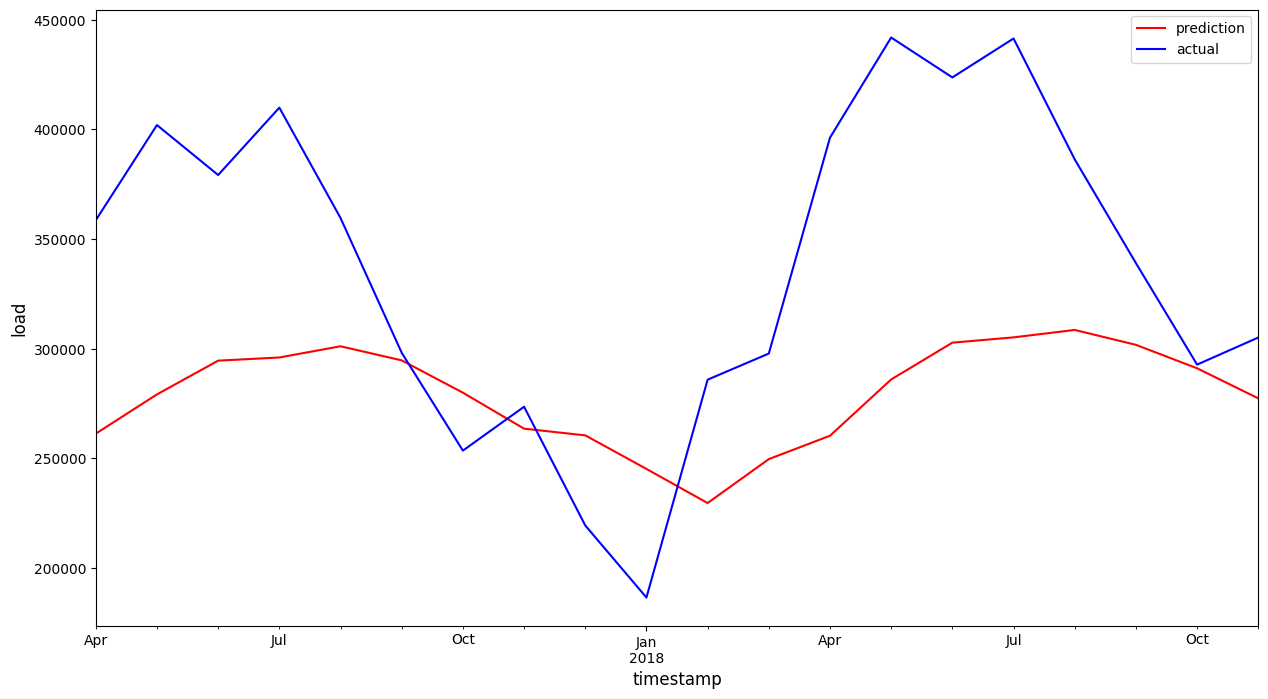

In [ ]:
eval_df[eval_df.timestamp<'2022-12'].plot(x='timestamp', y=['prediction', 'actual'], style=['r', 'b'], figsize=(15, 8))
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

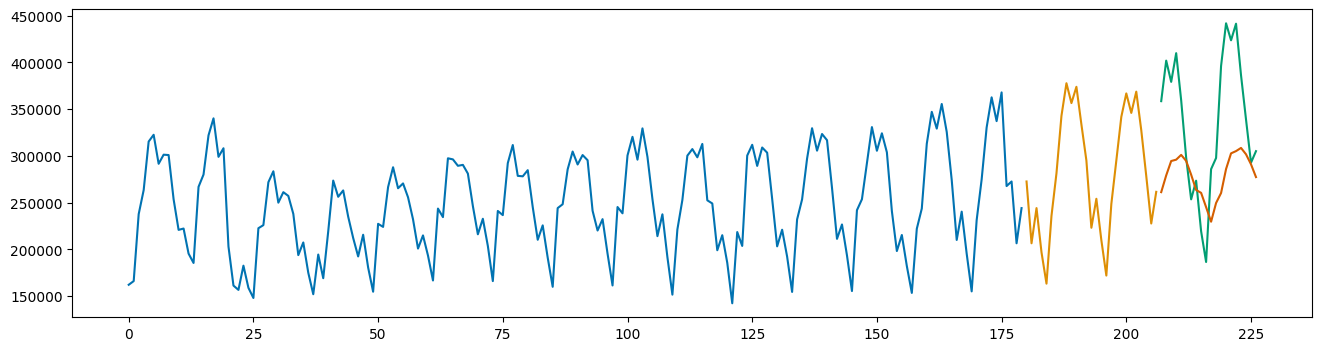

In [ ]:
train_to_plot = pd.Series(scaler.inverse_transform(train)[:,0])

validation_to_plot = pd.Series(scaler.inverse_transform(valid)[:,0])
validation_to_plot.index+=train_to_plot.index.stop


true_to_plot = eval_df["actual"]
true_to_plot.index+=validation_to_plot.index.stop

predict_to_plot = eval_df["prediction"]
predict_to_plot.index+=validation_to_plot.index.stop

plot_ys(train_to_plot, validation_to_plot, true_to_plot, predict_to_plot)